In [1]:
from time import sleep, time
from functions import *

In [2]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
rm = pyvisa.ResourceManager()
lr = rm.list_resources()
for r in lr:
    if "awg" in r:
        AWG = ArbitraryWaveformGenerator(r)
    elif "daq" in r:
        DAQ = DataAcquisition(r)
    elif "172.31.182.32" in r:
        SMU = SourceMeasureUnit(r)
    elif "osc" in r:
        OSC = Oscilloscope(r)

In [4]:
AWG.connect()
DAQ.connect()
SMU.connect()
OSC.connect()

In [5]:
AWG.reset()
SMU.reset()
DAQ.reset()
OSC.reset()

In [6]:
OSC.write("SYST:DISP:UPD 1")
DAQ.set_conn(123)

In [7]:
V, VOLT, n, T_AWG, DCYC_AWG, const_read, read_p, ch_AWG, SRAT_AWG = [1], 1, [1], [10**3], [.1], False, .1, 1, 1e7
wf_AWG = my_wf(V, n, T_AWG, DCYC_AWG, const_read, read_p)
AWG.set_wf(wf_AWG, SRAT_AWG, VOLT, ch_AWG)

In [8]:
V, VOLT, n, T_SMU, DCYC_SMU, const_read, read_p, ch_SMU, SRAT_SMU, aint = [1, .5], 1, [2, 2], [10**2, 10**2], [.2, .2], True, .1, 1, 1e4, False
wf_SMU = my_wf(V, n, T_SMU, DCYC_SMU, const_read, read_p)
read_V = read_p * VOLT
SMU.set_wf(wf_SMU, SRAT_SMU, VOLT, ch_SMU, aint=aint)

In [9]:
V, VOLT, n, T_SMU, DCYC_SMU, const_read, read_p, ch_SMU, SRAT_SMU, aint = [1], 1, [0], [1], [0], True, .1, 1, 1e4, True
wf_SMU_aint = my_wf(V, n, T_SMU, DCYC_SMU, const_read, read_p)
SMU.set_wf(wf_SMU_aint, SRAT_SMU, VOLT, ch_SMU, aint=aint)

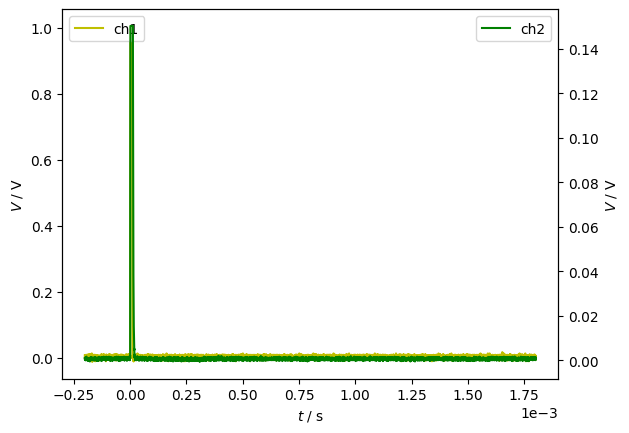

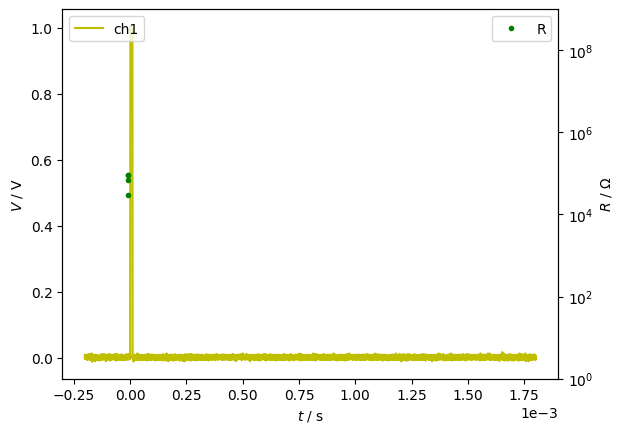

In [10]:
R, valid = meas_AWG(DAQ, 113, AWG, ch_AWG, T_AWG[0], read_V, VOLT, OSC, [1, 2])

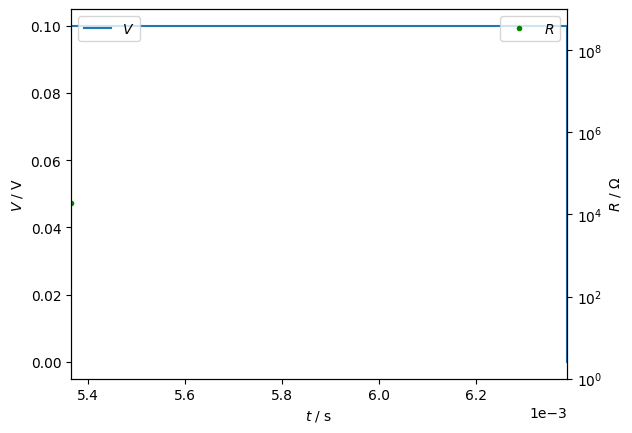

In [11]:
V_i, I_o, R, valid = meas_SMU(DAQ, 111, SMU, ch_SMU, T_SMU[0], read_V, VOLT, OSC, [1, 2], aint=aint)

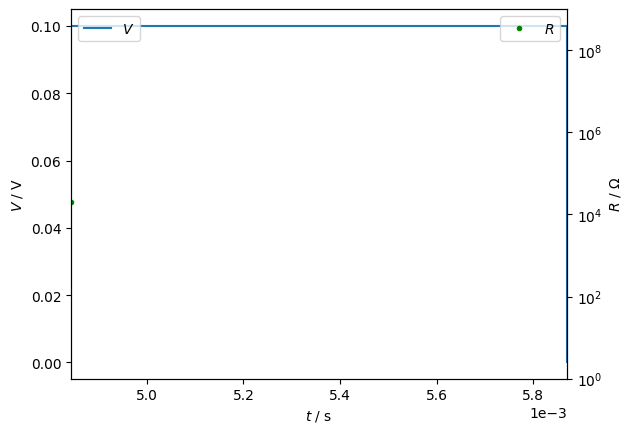

In [12]:
V_i, I_o, R, valid = meas_SMU_(DAQ, 111, SMU, ch_SMU, T_SMU[0], read_V, aint=aint)

In [13]:
N = 10
R = meas_AWG_SMU(N, DAQ, AWG, ch_AWG, SMU, ch_SMU, T_SMU[0], read_V)

In [14]:
R

[19513.48973607038,
 19327.513023345553,
 19481.29145532579,
 19498.577275384916,
 19478.96686159844,
 19458.996304220967,
 19560.964138741914,
 19325.01449835685,
 19513.0282375852,
 19530.710510863184]